In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tqdm
from tqdm import trange,tqdm_notebook


### Processing game image 

* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top & bottom)

In [3]:
from gym.core import ObservationWrapper
from gym.spaces import Box

import skimage
from skimage.transform import resize
from skimage.color import rgb2gray

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self,env)
        
        self.img_size = (64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size +(1,) )

    def observation(self, img):
        """what happens to each observation"""
        
        
        img = rgb2gray(
              resize(
                img[31:192,8:-8,:],self.img_size))
        
        img = np.float32(img)
        img = np.expand_dims(img, axis=2)
        
      
        return img


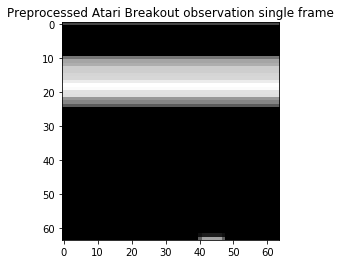

In [4]:
import gym
env = gym.make("BreakoutDeterministic-v0") #create raw env
env = PreprocessAtari(env)

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

obs = env.reset()


plt.title("Preprocessed Atari Breakout observation single frame")
plt.imshow(obs[:,:,0],interpolation='none',cmap='gray');



In [5]:
from framebuffer import FrameBuffer
def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

In [6]:
obs.shape

(64, 64, 1)

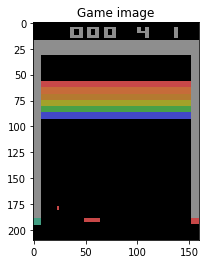

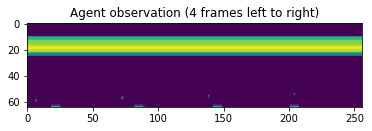

In [7]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0,2,1]).reshape([state_dim[0],-1]));

### Build the network


In [8]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [9]:
Dense = tf.keras.layers.Dense
Conv2D = tf.keras.layers.Conv2D
Flatten = tf.keras.layers.Flatten
Sequential = tf.keras.models.Sequential

In [11]:
class DQNAgent:
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False):
        """A simple DQN agent"""
        with tf.variable_scope(name, reuse=reuse):
            
            self.network = Sequential()
            self.network.add( Conv2D(filters=16, kernel_size = (3,3), strides =2, activation = 'relu',input_shape=state_shape) )
            self.network.add(Conv2D(32, (3, 3), strides=2, activation='relu'))
            self.network.add(Conv2D(64, (3, 3), strides=2, activation='relu'))
            self.network.add(Flatten())
            self.network.add(Dense(256, activation='relu'))
            self.network.add(Dense(n_actions, activation='linear'))
            
            # prepare a graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)
            
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon

    def get_symbolic_qvalues(self, state_t):
        """takes agent's observation, returns qvalues. Both are tf Tensors"""
        qvalues = self.network(state_t)
        
        return qvalues
    
    def get_qvalues(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})
    
    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

Using TensorFlow backend.


In [12]:
agent = DQNAgent("dqn_agent", state_dim, n_actions, epsilon=0.5)
sess.run(tf.global_variables_initializer())

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done: break
                
        rewards.append(reward)
    return np.mean(rewards)

In [14]:
evaluate(env, agent, n_games=1)

2.0

### Experience replay

Use a replay buffer to sample tuples from. Decorrelates samples in a batch.

In [15]:
from replay_buffer import ReplayBuffer

In [16]:
def play_and_record(agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer.    
    :returns: return sum of rewards over time
    """
    # initial state
    s = env.framebuffer

    reward = 0.0
    for t in range(n_steps):
        # get agent to pick action given state s
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        next_s, r, done, _ = env.step(action)
        
        # add to replay buffer
        exp_replay.add(s, action, r, next_s, done)
        reward += r
        if done:
            s = env.reset()
        else:
            s = next_s
    return reward        
    

### Target networks


In [17]:
target_network = DQNAgent("target_network", state_dim, n_actions)

In [18]:
def load_weigths_into_target_network(agent, target_network):
    """ assign target_network.weights variables to their respective agent.weights values. """
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
    tf.get_default_session().run(assigns)
    return assigns

In [19]:
def polyak_load_weights(agent, target_network):
    tau =0.999
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target,tau*w_target + (1-tau)*w_agent, validate_shape=True))
    tf.get_default_session().run(assigns)
    return assigns

In [20]:
# create the tf copy graph only once.
copy_step=load_weigths_into_target_network(agent, target_network) 
sess.run(copy_step)
# check that it works
sess.run([tf.assert_equal(w, w_target) for w, w_target in zip(agent.weights, target_network.weights)]);
print("It works!")

It works!


### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

In [21]:
# placeholders that will be fed with exp_replay.sample(batch_size)
obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
actions_ph = tf.placeholder(tf.int32, shape=[None])
rewards_ph = tf.placeholder(tf.float32, shape=[None])
next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
is_done_ph = tf.placeholder(tf.float32, shape=[None])

is_not_done = 1 - is_done_ph
gamma = 0.99

Take q-values for actions agent just took

In [22]:
current_qvalues = agent.get_symbolic_qvalues(obs_ph)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis=1)

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\phi}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ y = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

For Double DQN and using delayed target weights, new target y:

$$
y=r+\gamma Q_{\phi^{\prime}}\left(\mathbf{s}^{\prime}, \arg \max _{\mathbf{a}^{\prime}} Q_{\phi}\left(\mathbf{s}^{\prime}, \mathbf{a}^{\prime}\right)\right)
$$


In [23]:
DOUBLEDQN = False

In [24]:
if DOUBLEDQN:
    next_qvalues_target =  target_network.get_symbolic_qvalues(next_obs_ph) ### [batch, actions]
    next_actions_for_target = tf.argmax(current_action_qvalues, axis=-1)
    next_state_values_target = tf.reduce_sum(tf.one_hot(next_actions_for_target, n_actions) * next_qvalues_target, axis=1)
    reference_qvalues = rewards_ph + gamma*next_state_values_target*is_not_done
else:
    next_qvalues_target =  target_network.get_symbolic_qvalues(next_obs_ph) 
    next_state_values_target = tf.reduce_max(next_qvalues_target, axis=-1)
    reference_qvalues = rewards_ph + gamma*next_state_values_target*is_not_done

# Define loss function for sgd.
td_loss = (current_action_qvalues - tf.stop_gradient(reference_qvalues)) ** 2
td_loss = tf.reduce_mean(td_loss)

train_step = tf.train.AdamOptimizer(1e-3).minimize(td_loss, var_list=agent.weights)

Instructions for updating:
Use tf.cast instead.


In [25]:
sess.run(tf.global_variables_initializer())

In [26]:
tf.gradients(reference_qvalues, agent.weights)

[None, None, None, None, None, None, None, None, None, None]

In [27]:
tf.gradients(current_action_qvalues, agent.weights)

[<tf.Tensor 'gradients_2/sequential_1/conv2d_1/convolution_grad/Conv2DBackpropFilter:0' shape=(3, 3, 4, 16) dtype=float32>,
 <tf.Tensor 'gradients_2/sequential_1/conv2d_1/BiasAdd_grad/BiasAddGrad:0' shape=(16,) dtype=float32>,
 <tf.Tensor 'gradients_2/sequential_1/conv2d_2/convolution_grad/Conv2DBackpropFilter:0' shape=(3, 3, 16, 32) dtype=float32>,
 <tf.Tensor 'gradients_2/sequential_1/conv2d_2/BiasAdd_grad/BiasAddGrad:0' shape=(32,) dtype=float32>,
 <tf.Tensor 'gradients_2/sequential_1/conv2d_3/convolution_grad/Conv2DBackpropFilter:0' shape=(3, 3, 32, 64) dtype=float32>,
 <tf.Tensor 'gradients_2/sequential_1/conv2d_3/BiasAdd_grad/BiasAddGrad:0' shape=(64,) dtype=float32>,
 <tf.Tensor 'gradients_2/sequential_1/dense_1/MatMul_grad/MatMul_1:0' shape=(3136, 256) dtype=float32>,
 <tf.Tensor 'gradients_2/sequential_1/dense_1/BiasAdd_grad/BiasAddGrad:0' shape=(256,) dtype=float32>,
 <tf.Tensor 'gradients_2/sequential_1/dense_2/MatMul_grad/MatMul_1:0' shape=(256, 4) dtype=float32>,
 <tf.Tens

In [28]:

from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import DataFrame
moving_average = lambda x, span=100, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(span=span, **kw).mean().values
%matplotlib inline

mean_rw_history = []
td_loss_history = []

In [29]:
exp_replay = ReplayBuffer(10**5)
play_and_record(agent, env, exp_replay, n_steps=10000)

def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        obs_ph:obs_batch, actions_ph:act_batch, rewards_ph:reward_batch, 
        next_obs_ph:next_obs_batch, is_done_ph:is_done_batch
    }

buffer size = 100000, epsilon = 0.12367


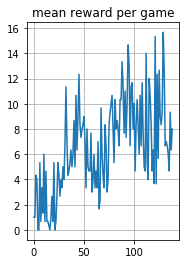

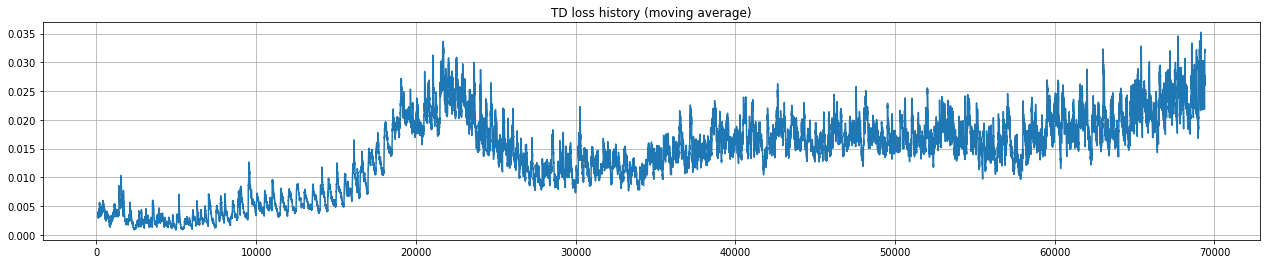

 14%|█▍        | 69499/500000 [1:30:30<8:05:37, 14.77it/s] 

KeyboardInterrupt: 

In [30]:
for i in trange(5*(10**5)): 
    
    # play
    play_and_record(agent, env, exp_replay, 10)
    
    # train
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=64))
    td_loss_history.append(loss_t)
    
    # adjust agent parameters
    if i % 500 == 0:
        sess.run(copy_step)
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))
    
    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[48, 4])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(moving_average(np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()
        
        

### Video

In [31]:
#record sessions
import gym.wrappers

agent.epsilon=0
env_monitor = gym.wrappers.Monitor(make_env(),directory="videos",force=True)
sessions = [evaluate(env_monitor, agent, n_games=1) for _ in range(100)]
env_monitor.close()

In [1]:

#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) 

